### Install python for open source geospatial 3D modelling

1. Create a conda environment for this project. You should have installed conda or miniconda already for this to run.
```
conda env create -f ./3dworkbench.yml
```
2. Install pyfor library and dependancies. This will take a while due to dependancies heavy files.

3. If necessary, convert the LAZ file to LAS (You can do this using the LASTools Plugin on QGIS)

4. Follow [this](https://geonetcast.wordpress.com/2022/05/12/creating-a-geotiff-from-a-numpy-array/) for exporting np array to GeoTiff.

This notebook presents methods for making a digital surface model (DSM) from a LiDAR point cloud and then converting the DSM into a grid mesh. 

The main learning objectives of this assignment can be summarized as below:

* building hands-on skills with professional libraries for 3D geospatial computing
* grasping the tangible meaning of 3D data modelling: from a point cloud to a DSM and a grid mesh
* learning numpy in action for transforming data-structures 
* grasping the basics of python programming in terms of data flow and flow control

## Import Libraries

prior to importing these libraries you have to selecct and enable the right kernel for your Jupyter Notebook. This kernel is the particular python executeable that is located in a conda environment. We have proposed a simple way to build a conda environment from the yml description file. If you want to learn more about conda environments and vscode watch [this tutorial: Pythonics0](https://www.youtube.com/watch?v=mSaFTboRtB4&ab_channel=PirouzNourian).

In [1]:
import laspy                    #point cloud operations
import open3d as o3d            #a 3d library for python, very much oriented toward computer vision applications, written in C++ and python wrapped
import numpy as np              #the most essential library for numerical and scientific computing. It transforms python to something like MATLAB
import trimesh as tm            #a 3d geometric computing library for mesh processing
import shapely                  #a 2D vector GIS computing library, quite essential for operations on points, lines, and polygons
import geopandas                #an extension of pandas for working with vector-data (points, lines, polygons) in GIS
import rasterio                 #a python library for raster GIS operations
import rasterio.plot            #the plotting namespace of the rasterio library for plotting DSMs and other such raster datasets
from osgeo import gdal, osr, ogr# Python bindings for GDAL which are installed when installing geopandas 
import matplotlib.pyplot as plt #the most versatile plotting library of python
import pickle                   #a binary serialization tool native to python used for packing data and transferring it efficiently
import os                       #a native python library for accssing the Operation System's specific file-path formulation methods

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


### Import Files

In [2]:
# reading encoded and compressed point data from a particular file format and converting it to a bunch of universally undertandable primitives like floats
las = laspy.read('../Data/OldCityEnschede.las')

### Transform data into a Open3D point cloud and visualize

In [5]:
# composing an array or a vector/matrix of 3D points and reshaping it by numpy to appropriate it for the next data input operation. Check the shape of this array before the transpose operation to see why we are transposing it. 
point_data = np.stack([las.X, las.Y, las.Z], axis=0).transpose((1,0))

In [6]:
# note how the open3d library expects to receive a pointcloud as a rectangular array
geom = o3d.geometry.PointCloud()
geom.points = o3d.utility.Vector3dVector(point_data)

after running the next cell you should be able to see this in a separate window (close the window to save computational power):

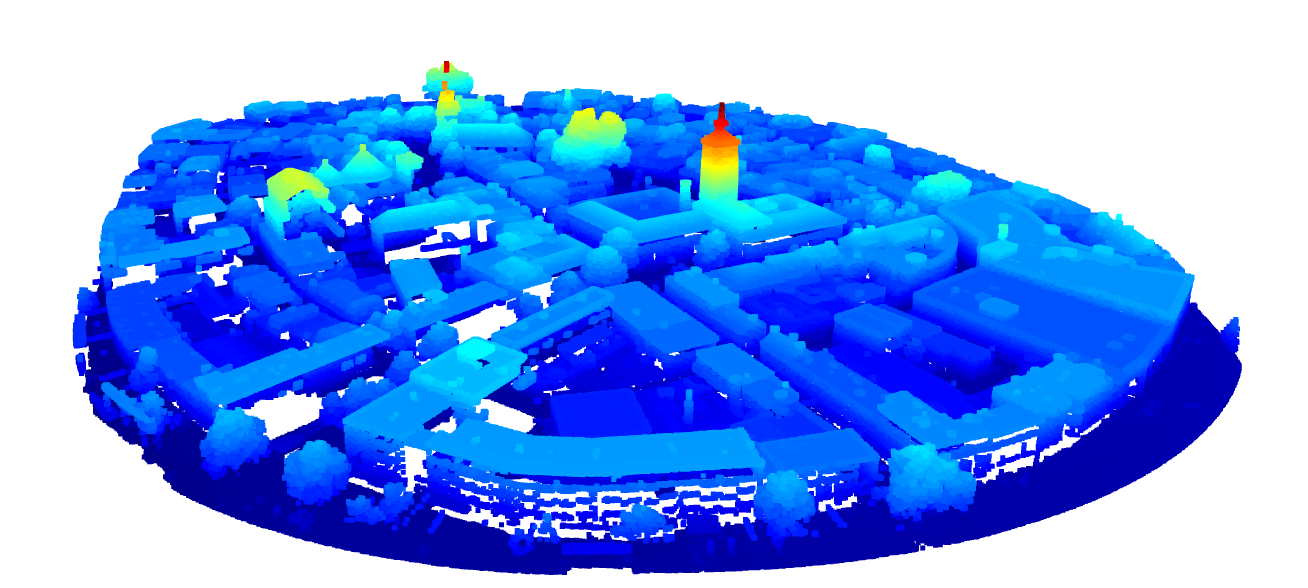

In [7]:
o3d.visualization.draw_geometries([geom])

[Open3D WARNING] GLFW Error: WGL: Failed to make context current: The handle is invalid. 


#### convert open3D object into a np array and transform into meters and create a new point cloud


In [8]:
## convert open3D object into a np array and transform into meters and create a new point cloud
xyz_load = (np.asarray(geom.points))/1000
newGeom= o3d.geometry.PointCloud()
newGeom.points = o3d.utility.Vector3dVector(xyz_load)

In [9]:
#get boundaries and size of the diagonal
#a boudning box is effectively a tuple of two points or 6 numbers. To construct a bounding box we use numpy. The axis=0 tells numpy to perform the operation on the columns of the array. If we needed to perform the operation on the rows we would have put axis=1, this is because the columnar direction is the first default arraying direction in numpy. 

minb= np.min(xyz_load, axis=0)
maxb= np.max(xyz_load, axis=0)

diagonal = (maxb - minb)
diagonal


(3,)


In [16]:
# create a bounding box as a tuple of two 3D points. Note how we use tuples to quickly pack data. This is a common trick also used to transfer other things like rays. The interpretation of the tuple in a specific context gives it a geometric meaning, however, the data package in itself does not contain any explicit geometric meaning.
bbox = (minb,maxb)
bbox

(array([2.57918444e+05, 4.71075511e+05, 3.99730000e+01]),
 array([2.58294134e+05, 4.71489192e+05, 9.44930000e+01]))

#### define Pixel size and bounding Box

The theory of geospatial voxelization is explained in these two papers: 
* [Geospatial Voxelization Algorithms](https://www.researchgate.net/publication/290507635_Voxelization_Algorithms_for_Geospatial_Applications)
* [Voxel Graph Operators](https://www.researchgate.net/publication/374477303_Voxel_Graph_Operators_Topological_Voxelization_Graph_Generation_and_Derivation_of_Discrete_Differential_Operators_from_Voxel_Complexes)

In [15]:
# pixelization is a 2D version of voxelization; thus a mapping from R2 to Z2 to N2. Read the second paper mentioned above for more information. 

pixsize =np.array([5,5])
bboxR2 = ([minb[0],minb[1]],[maxb[0],maxb[1]])
bboxR2

([257918.444, 471075.511], [258294.134, 471489.192])

In [16]:
# this is an element-wise (Hadamard-Schur) division of two arrays that is performed correctly thanks to NumPy 'broadcasting' between the two arrays
# in here we directly map the bounding box from the space of real numbers to the space of natural numbers without passing through the integer numbers because we know that our cooredinates are positive (because Enschde has positive geographical coordinates in the first quadrant). Had the site been located in any other quadrant of the geographical space, however, we would have to subtract the minimum corner of the bounding box from the integer coordinates to ensure that they are positive. Check the second paper mentioned above for more details. You can also consider adding a couple of lines to subtract the minimum corner of the bbox in Z2 to ensure that the same code works for other locations in the globe. 
bboxN2 = bboxR2/pixsize
bboxN2

array([[51583.6888, 94215.1022],
       [51658.8268, 94297.8384]])

In [17]:
#after the division by a vector showing the pixel-size or voxel-size the next step of rasterization is to round the scaled coordinates to the nearest integers, which is performed here using the Nearest Integer function of numpy directly on all members of the array. Note that numpy has explicit data types unlike python and here we are casting the results into an array of integers to ensure that they are in the space of N2.
bboxN2=np.rint(bboxN2).astype(int)
bboxN2

array([[51584, 94215],
       [51659, 94298]])

In [18]:
# the diagonal vector of a bounding box in N2 essentially becomes a tuple of 2 numbers that show the size of the bounding box. Since this bounding box is defined in the 2-dimensional space of positive integers, its diagonal basically shows the number of pixesl in X and Y directions. We shall use these two numbers as enumerators of the nested loops that will create the pixels of the Digital Surface Model in the following cells. Note how a tuple of two numbers is assigned in the 3rd line of this cell. 
diagonalN2=bboxN2[1]-bboxN2[0]
diagonalN2 

(m,n)=diagonalN2
m,n

(75, 83)

In the following cell we perform an algorithm that creates pixel polygons for constructing a DSM, use Open3D to clip the point cloud into the points falling within that polygon (effectively a bounding box in R2), get the average height of those points falling into the pixel bbox and create a pixel point as the centre of this bbox first in R2 and then add the average height to it to make a 2.5D pixel-point in R3. We make this latter point to later use it for creating a grid mesh. 

In [19]:
pixelsR2=[]
pixelPolygons=[]
pixelsR3=np.zeros((m,n,3))
heightMap=np.zeros((m,n))
DEMVertices=[]
for i in range(m):
    for j in range(n):
        
        pixelN2 = [i,j]
        pixelR2 = (pixelN2*pixsize)+bboxR2[0]
        
        pixelsR2.append(pixelR2)
        halfDiagonal = 0.5*pixsize
        pixelBBBl=(pixelR2-halfDiagonal).reshape(-1)
        pixelBBTr=(pixelR2+halfDiagonal).reshape(-1)
        minBound=np.append(pixelBBBl,minb[2])
        maxBound=np.append(pixelBBTr,maxb[2])
        bounds=[minBound,maxBound]
        tempPoints=o3d.geometry.PointCloud()
        tempBounds=tempPoints.points=o3d.utility.Vector3dVector(bounds)
        smallBB=o3d.geometry.AxisAlignedBoundingBox.create_from_points(tempBounds)
        pixelBB=(pixelBBBl[0],pixelBBBl[1],pixelBBTr[0],pixelBBTr[1])
        pixelPolygon=shapely.geometry.box(*pixelBB,ccw=True)
        pixelPolygons.append(pixelPolygon)
        pixelPC=newGeom.crop(smallBB) #crop(self, bounding_box)
        pcArray=np.asarray(pixelPC.points)
        averageHeight=0
        if pcArray.shape[0]>0:
            averageHeight=np.average(pcArray,axis=0)[2]

        else:
            averageHeight=0
        j=n-1-j
        pixelR3=np.array([*pixelR2,averageHeight])
        pixelsR3[i,j]=pixelR3
        
        heightMap[i,j]=averageHeight
        DEMVertices.append(pixelR3)




array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

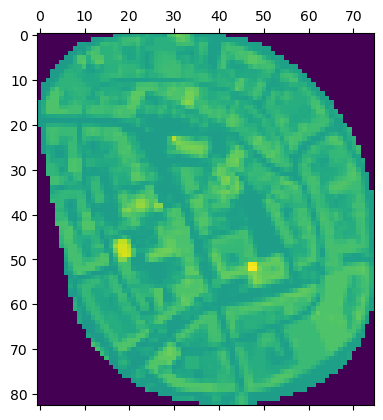

In [20]:
# this heightmap is practically the DSM that we wanted to create. However, to be legible as a proper DSM we need to write it with proper metadata using rasterio. We will do this in a couple of cells below. We noticed that we needed to transpose the heightmap in QGIS when we visualized the DSM on a base map. 
heightMap=heightMap.transpose()
plt.matshow(heightMap)
heightMap

The following three cells are just to visualize the pixel centres on a 2D plane to ensure that they are created properly. 

In [21]:
#points=np.stack(pixelsR2, axis=0)
points=np.array(pixelsR2)
points.shape

points=points.reshape(points.shape[0],points.shape[1])
points

array([[257918.444, 471075.511],
       [257918.444, 471080.511],
       [257918.444, 471085.511],
       ...,
       [258288.444, 471475.511],
       [258288.444, 471480.511],
       [258288.444, 471485.511]])

In [22]:
points3D=np.c_[points,np.zeros(points.shape[0])]
points3D

array([[257918.444, 471075.511,      0.   ],
       [257918.444, 471080.511,      0.   ],
       [257918.444, 471085.511,      0.   ],
       ...,
       [258288.444, 471475.511,      0.   ],
       [258288.444, 471480.511,      0.   ],
       [258288.444, 471485.511,      0.   ]])

In [23]:
#vizulise points of the new array.

geom = o3d.geometry.PointCloud()
geom.points = o3d.utility.Vector3dVector(points3D)
o3d.visualization.draw_geometries([geom])

In [30]:
# checking the geographical extents of the DSM
def getGeoTransform(extent, nlines, ncols):
    resx = (extent[2] - extent[0]) / ncols
    resy = (extent[3] - extent[1]) / nlines
    return [extent[0], resx, 0, extent[3] , 0, -resy]
# Define the data extent (min. lon, min. lat, max. lon, max. lat)
extent = [*bboxR2[0],*bboxR2[1]]
extent



[257918.444, 471075.511, 258294.134, 471489.192]

In [31]:
# Export the test array to GeoTIFF ================================================
 
# Get GDAL driver GeoTiff
driver = gdal.GetDriverByName('GTiff')
 
# Get dimensions
nlines = heightMap.shape[0]
ncols = heightMap.shape[1]
nbands = 1
data_type = gdal.GDT_Float32

In [32]:
# Create a temp grid
#options = ['COMPRESS=JPEG', 'JPEG_QUALITY=80', 'TILED=YES']
grid_data = driver.Create('height_map', ncols, nlines, 1, data_type)#, options)
 
# Write data for each bands
grid_data.GetRasterBand(1).WriteArray(heightMap)

# Lat/Lon WSG84 Spatial Reference System
srs = osr.SpatialReference()
srs.SetFromUserInput("EPSG:28992") #RD_New EPSG code

0

In [33]:
# Setup projection and geo-transform
grid_data.SetProjection(srs.ExportToWkt())
grid_data.SetGeoTransform(getGeoTransform(extent, nlines, ncols))
 
# Save the file
file_name = '../Results/height_map.tif'
print(f'Generated GeoTIFF: {file_name}')
driver.CreateCopy(file_name, grid_data, 0)  

# Close the file
driver = None
grid_data = None
 
# Delete the temp grid
import os                
os.remove('height_map')


Generated GeoTIFF: ../Results/height_map.tif


In [34]:
# Here we are going to visualize the GeoTiff raster with rasterio, take a look at this course: https://automating-gis-processes.github.io/CSC/notebooks/L5/reading-raster.html

# Data dir
#data_dir = "L5_data"
fp = '../Results/height_map.tif'#os.path.join(data_dir, "Helsinki_masked_p188r018_7t20020529_z34__LV-FIN.tif")

# Open the file:
raster = rasterio.open(fp)

# Check type of the variable 'raster'
type(raster)
raster.crs
raster.meta

{'driver': 'GTiff',
 'dtype': 'float32',
 'nodata': None,
 'width': 75,
 'height': 83,
 'count': 1,
 'crs': CRS.from_epsg(28992),
 'transform': Affine(5.009200000000031, 0.0, 257918.444,
        0.0, -4.984108433734726, 471489.192)}

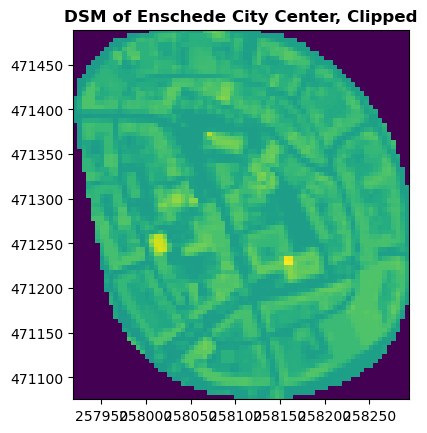

<Axes: title={'center': 'DSM of Enschede City Center, Clipped'}>

: 

In [30]:
rasterio.plot.show(raster, title = "DSM of Enschede City Center, Clipped")

Here we are going to make a mesh using [this tutorial](https://www.slideshare.net/PirouzNourian/tu-delft-geo1004-2015-point-cloud-processing-estimating-normal-vectors-and-curvature-indicators-using-eigenvectors) check the page number 41. The idea is to use the regularity of the pixels produced in the two nested loops above and form quadrilateral faces or two triangles for each quadruple of vertices when marching a pivotal corner vertex through the grid in two directions. Draw on a piece of paper what is happening to understand this better. I have added a hand drawing here: 

[Grid Meshing: Converting Pixels to a Grid Mesh](https://github.com/Generative-Systems-Sciences/Enschede_3dWorkbench/blob/9f81a2de35e64510ea17d8f3997c2d64a634c205/GridMeshing.jpg)


In [36]:
# the only difference between the following and the method that I had introduced in the tutorial linked above is that here we have to create triangular faces because we are using the TriMesh library. This library does not support quadrilateral faces. However, the essence of the quadrilateral marching is the same. Perhaps you can think of an improvement in the algorithm to decide on the direction of triangulation depending on the height differences to make a smoother mesh. Can you imagine what I mean? Play with a piece of A4 paper and pull up one of the corners from the table surface to get a feel of a non-planar quadrilateral and think of the best triangulation that could represent that surface and observe the jaggedness of the triangulation in the opposite direction (with the other diagonal). 
vertexIndices=[]
faceList=[]

for i in range(m-1):
    for j in range(n-1):
        v0= i*n+j
        v1=v0+1
        v2=v0+n
        v3=v1+n
        tbl = [v0,v2,v1]
        ttr = [v1,v2,v3]
        faceList.append(tbl)
        faceList.append(ttr)

faceArray=np.array(faceList)
faceArray

array([[   0,   83,    1],
       [   1,   83,   84],
       [   1,   84,    2],
       ...,
       [6140, 6222, 6223],
       [6140, 6223, 6141],
       [6141, 6223, 6224]])

In [37]:
mesh=tm.Trimesh(vertices=DEMVertices,faces=faceArray)
mesh.show()

In [38]:
with open('mesh.pkl', 'wb') as file:
    pickle.dump(mesh, file)

In [39]:
# tempMesh = mesh.copy()
f=mesh.export(file_obj='../Results/mesh.obj',file_type='obj')
f

'# https://github.com/mikedh/trimesh\nv 257918.44400000 471075.51100000 0.00000000\nv 257918.44400000 471080.51100000 0.00000000\nv 257918.44400000 471085.51100000 0.00000000\nv 257918.44400000 471090.51100000 0.00000000\nv 257918.44400000 471095.51100000 0.00000000\nv 257918.44400000 471100.51100000 0.00000000\nv 257918.44400000 471105.51100000 0.00000000\nv 257918.44400000 471110.51100000 0.00000000\nv 257918.44400000 471115.51100000 0.00000000\nv 257918.44400000 471120.51100000 0.00000000\nv 257918.44400000 471125.51100000 0.00000000\nv 257918.44400000 471130.51100000 0.00000000\nv 257918.44400000 471135.51100000 0.00000000\nv 257918.44400000 471140.51100000 0.00000000\nv 257918.44400000 471145.51100000 0.00000000\nv 257918.44400000 471150.51100000 0.00000000\nv 257918.44400000 471155.51100000 0.00000000\nv 257918.44400000 471160.51100000 0.00000000\nv 257918.44400000 471165.51100000 0.00000000\nv 257918.44400000 471170.51100000 0.00000000\nv 257918.44400000 471175.51100000 0.000000